# Swish-based classifier
- Swish activation, 4 layers, 100 neurons per layer
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [3]:
nSplits = 10
patience = 50
maxEpochs = 200

ensembleSize = 10
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelSwish', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
trainData = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 12.690s 


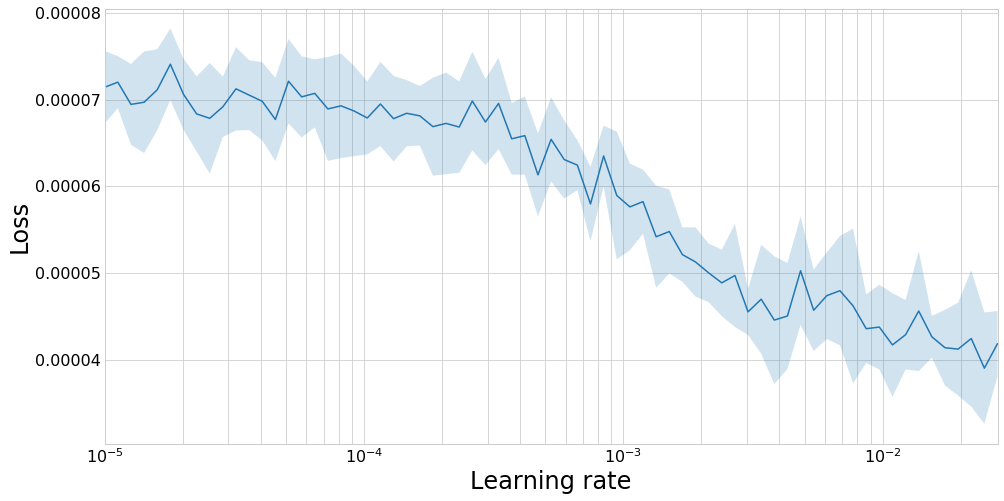

______________________________________



In [5]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

## Train classifier

Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 3.764938268606267e-05
2 New best found: 3.580075711759891e-05
3 New best found: 3.5560888481416496e-05
4 New best found: 3.5256727092643325e-05
5 New best found: 3.484085595694938e-05
6 New best found: 3.4225062661884265e-05
12 New best found: 3.372408178429985e-05
20 New best found: 3.348840763580745e-05
21 New best found: 3.34608577489443e-05
24 New best found: 3.322665605665454e-05
33 New best found: 3.312364405015671e-05
41 New best found: 3.2961195363584514e-05
73 New best found: 3.287217309968368e-05
Early stopping after 123 epochs
Score is: {'loss': 3.287217309968368e-05, 'wAUC': 0.06736995874085205, 'AUC': 0.10398666986619853, 'AMS': 3.746045232897812, 'cut': 0.9254051446914673}
Fold took 110.023s

Running fold 2 / 10
1 New best found: 3.818367544217199e-05
2 New best found: 3.660746862208664e-05
3 New best found: 3.5600427092002e-05
4 New best found: 3.531399201166198e-05
5 Ne

46 New best found: 3.166691481551677e-05
48 New best found: 3.1565685047269115e-05
65 New best found: 3.1517850386943924e-05
Early stopping after 115 epochs
Score is: {'loss': 3.1517850386943924e-05, 'wAUC': 0.06259619706576136, 'AUC': 0.10033086032838245, 'AMS': 3.493892154887475, 'cut': 0.9437617063522339}
Fold took 109.645s


______________________________________
Training finished
Cross-validation took 1056.199s 


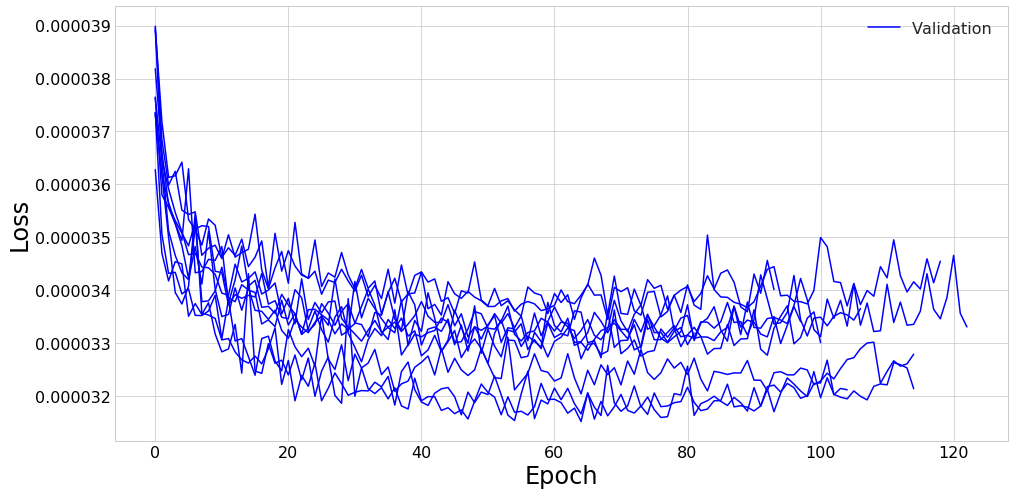

Mean loss = 3.26e-05 +- 2e-07
Mean wAUC = 0.0667 +- 0.0008
Mean AUC = 0.1057 +- 0.0009
Mean AMS = 3.57 +- 0.03
Mean cut = 0.942 +- 0.006
______________________________________



In [6]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, 
                                          {**modelParams, 'compileArgs':{**compileArgs, 'lr':2e-3}},
                                          trainParams, trainOnWeights=True, maxEpochs=maxEpochs,
                                          patience=patience, verbose=1, amsSize=250000)

Comparing to the ReLU baseline, the Swish model reaches a lower loss (3.26e-5 compared to 3.29e-5) and a higher AMS (3.57 compared to 3.49)

## Construct ensemble

In [7]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [8]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 9 with loss = 3.1517850386943924e-05
Model 1 is 6 with loss = 3.153622250974877e-05
Model 2 is 3 with loss = 3.203990302135935e-05
Model 3 is 4 with loss = 3.261863795487443e-05
Model 4 is 1 with loss = 3.264724685976263e-05
Model 5 is 2 with loss = 3.2849627999623695e-05
Model 6 is 0 with loss = 3.287217309968368e-05
Model 7 is 7 with loss = 3.3043644119649506e-05
Model 8 is 5 with loss = 3.344735617865808e-05
Model 9 is 8 with loss = 3.352967506432873e-05


## Response on validation data

In [9]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [10]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.001477591016000042s per sample

Predicting batch 2 out of 10
Prediction took 0.0003098059632000513s per sample

Predicting batch 3 out of 10
Prediction took 0.0003072094494000339s per sample

Predicting batch 4 out of 10
Prediction took 0.0002752408397998806s per sample

Predicting batch 5 out of 10
Prediction took 0.0003348574699999517s per sample

Predicting batch 6 out of 10
Prediction took 0.0002946753271999114s per sample

Predicting batch 7 out of 10
Prediction took 0.00027772829280002043s per sample

Predicting batch 8 out of 10
Prediction took 0.0002975080293999781s per sample

Predicting batch 9 out of 10
Prediction took 0.00031578998579989275s per sample

Predicting batch 10 out of 10
Prediction took 0.00031417464700007257s per sample



In [11]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.8986189185747548, weighted 0.9340172637209634


In [12]:
amsScanSlow(convertToDF(valData.source))

50000 candidates loaded


(3.78029611409427, 0.94643664)

In [13]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

50000 candidates loaded

Mean AMS=3.8+-0.1, at mean cut of 0.94+-0.01
Exact mean cut 0.9438693160191178, corresponds to AMS of 3.7210127203215
CPU times: user 2.16 s, sys: 9.37 s, total: 11.5 s
Wall time: 2min 52s


(3.8, 0.94)

Comparing the Swish model to the ReLU baseline on the validation data, we find improvements in both the overall AMS (3.78 c.f. 3.72) and the AMS corresonding to the mean cut (3.72 c.f. 3.64).

Since the Swish model shows improvements in both the training and validation data we can conclude that the Swish activation function provides genuine, reproducable improvements to the architecture.

# Test scoring

In [6]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [7]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00023388337056358895s per sample

Predicting batch 2 out of 10
Prediction took 0.00019228974223640927s per sample

Predicting batch 3 out of 10
Prediction took 0.00020187610501822996s per sample

Predicting batch 4 out of 10
Prediction took 0.0002118941506363626s per sample

Predicting batch 5 out of 10
Prediction took 0.0001977680055818134s per sample

Predicting batch 6 out of 10
Prediction took 0.00020618791220000605s per sample

Predicting batch 7 out of 10
Prediction took 0.00019535982758183806s per sample

Predicting batch 8 out of 10
Prediction took 0.00019116296654544634s per sample

Predicting batch 9 out of 10
Prediction took 0.00019412337819998024s per sample

Predicting batch 10 out of 10
Prediction took 0.00019110521138182693s per sample

CPU times: user 2min 16s, sys: 6.01 s, total: 2min 22s
Wall time: 1min 50s


In [8]:
scoreTestOD(testData.source, 0.9438693160191178)

Public:Private AMS: 3.626311076586353 : 3.6543513373329155


(3.626311076586353, 3.6543513373329155)

# Save/Load

In [4]:
name = "weights/Swish"

In [19]:
saveEnsemble(name, ensemble, weights, compileArgs)

In [5]:
ensemble, weights, compileArgs, _, _ = loadEnsemble(name)